# Setup

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, fbeta_score, roc_curve, auc, brier_score_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.svm import SVC

#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation
#import keras.backend as K
#from keras.optimizers import SGD, Adam

#from brew.base import Ensemble, EnsembleClassifier
#from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
#from brew.combination.combiner import Combiner

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


/home/gordon/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data pre process

In [2]:
dt_path = "../data/kdd2009/"

In [3]:
#first 190 features are numerical and the last 40 are categorical
X = pd.read_table(dt_path+"orange_small_train.data")
X.shape

(50000, 230)

## features transformation

In [4]:
num_features = list(X.columns[:190])
cat_features = list(X.columns[190:230])

In [5]:
empty_features = []
c = 0.3
for feat in X.columns:
    nulls = X[feat].isnull().value_counts()
    try:
        not_nulls = nulls[False]
        if not_nulls < c*40000:
            empty_features.append(feat)
    except:    
        empty_features.append(feat)
print ("number of empty features is", len(empty_features))

number of empty features is 154


In [6]:
#remove sparse features
for feat in empty_features:
    #data.drop(feat, axis = 1, inplace = True)    
    if feat in num_features:
        num_features.remove(feat)
    else:
        cat_features.remove(feat)
    X.drop(feat,axis=1, inplace=True)

## missing value imputation

In [7]:
#Numeric features: replace missing values with (max value + 1).
maxs = X.max(axis = 0)
for i,feat in enumerate(num_features):
    fill_value = maxs[i] + 1.
    X.fillna({feat: fill_value}, inplace=True)

In [8]:
#Categorial features: replace values with their frequencies.
data_cat_all = X[cat_features]

for feat in data_cat_all.columns:
    data_cat_all[feat] = data_cat_all[feat].map(data_cat_all.groupby(feat).size())
    
X[cat_features] = data_cat_all.loc[:39999,:]

In [9]:
#Categorial features: replace missing values with zeros.
X.fillna(0., inplace=True)

## Load target valuable

In [10]:
y = pd.read_table(dt_path+"orange_small_train_churn.labels",header=None)
y.shape

(50000, 1)

In [11]:
y = LabelEncoder().fit_transform(y)

In [12]:
pd.Series(y).value_counts() 

0    46328
1     3672
dtype: int64

## get data ready for training

In [67]:
#normalization 
Scaler = MinMaxScaler()
X = pd.DataFrame(Scaler.fit_transform(X),columns=X.columns,index=X.index)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2018, stratify=y)

# Modeling

## Single Light GBM model

In [15]:
lgb_params = {'max_depth': 10, 'learning_rate': 0.01, 'random_state': 2018, 'cat_features':cat_features}
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt',
        cat_features=['Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var214', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229'],
        colsample_bytree=1.0, learning_rate=0.01, max_bin=255,
        max_depth=10, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
        objective=None, random_state=2018, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [16]:
y_pred_proba = lgb.predict_proba(X_test)[:, 1]

In [17]:
recall_score(y_test, lgb.predict(X_test))

0.013623978201634877

In [18]:
roc_auc_score(y_test, y_pred_proba)

0.7122628595592218

## Multi Models

In [19]:
import sys
sys.path.append('../src/model')
from model_training_eval import model_training_eval

In [20]:
SEED = 2018
MAX_DEPTH = [5,10,15]
LEARNING_RATE = [0.01,0.05,0.1]

In [21]:
gbm_params = {
#    'n_estimators': [100],
    'max_depth': MAX_DEPTH,
    'learning_rate': LEARNING_RATE,
    'random_state': [SEED]
}

In [22]:
xgb_params = {
    'max_depth': MAX_DEPTH,
    'learning_rate': LEARNING_RATE,
    'seed':[SEED]
}

In [23]:
catb_params = {
    'iterations': [100],
    'learning_rate': LEARNING_RATE,
    'depth': MAX_DEPTH,
}

In [24]:
lgb_params = {'max_depth': MAX_DEPTH, 'learning_rate': LEARNING_RATE}

In [25]:
classifiers = [
    (GradientBoostingClassifier(n_estimators=100), gbm_params),
    (LogisticRegression(), None),
    (RandomForestClassifier(n_estimators = 1000), None),
    #(KNeighborsClassifier(),None),
    (XGBClassifier(), xgb_params),
    (CatBoostClassifier(loss_function='Logloss'), catb_params),
    (LGBMClassifier(cat_features=cat_features), lgb_params),
    (GaussianNB(), None),
    (QuadraticDiscriminantAnalysis(), None),
#    (SVC(kernel="poly"), None) removed due to training time 
]

In [26]:
modeling = model_training_eval(classifiers, X_train, X_test, y_train, y_test)

In [27]:
eva = modeling.get_performance()

GradientBoostingClassifier is finished after 1:20:11.297281 HPT. 
The execution time of the best model is 0:00:31.590477.

LogisticRegression is finished after 0:00:00.000002 HPT. 
The execution time of the best model is 0:00:00.882980.

RandomForestClassifier is finished after 0:00:00.000003 HPT. 
The execution time of the best model is 0:02:01.697789.

XGBClassifier is finished after 0:01:15.642437 HPT. 
The execution time of the best model is 0:00:02.026830.

CatBoostClassifier is finished after 0:45:03.271265 HPT. 
The execution time of the best model is 0:00:11.437100.

LGBMClassifier is finished after 0:00:05.269806 HPT. 
The execution time of the best model is 0:00:00.202465.

GaussianNB is finished after 0:00:00.000003 HPT. 
The execution time of the best model is 0:00:00.064977.

QuadraticDiscriminantAnalysis is finished after 0:00:00.000002 HPT. 
The execution time of the best model is 0:00:00.097482.



## Model Performance

### Summary

In [28]:
modeling.get_models()

[GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=5,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=2018, subsample=1.0, verbose=0,
               warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min

### Performance

In [29]:
eva

,roc_auc_score,precision_score,recall_score,fbeta_score,brier_score_loss,execusion_time,hpt_time
GradientBoostingClassifier,0.750142,0.607143,0.0231608,0.0286775,0.063304,0:00:31.590477,1:20:11.297281
LogisticRegression,0.708184,0,0,0,0.0648318,0:00:00.882980,0:00:00.000002
RandomForestClassifier,0.71324,0,0,0,0.0649054,0:02:01.697789,0:00:00.000003
XGBClassifier,0.750892,0.785714,0.0149864,0.0186441,0.0629843,0:00:02.026830,0:01:15.642437
CatBoostClassifier,0.747256,0.592593,0.0217984,0.0269997,0.0627444,0:00:11.437100,0:45:03.271265
LGBMClassifier,0.721548,0,0,0,0.0884136,0:00:00.202465,0:00:05.269806
GaussianNB,0.623357,0.0796627,0.862398,0.290847,0.704745,0:00:00.064977,0:00:00.000003
QuadraticDiscriminantAnalysis,0.641687,0.095834,0.76158,0.318736,0.470773,0:00:00.097482,0:00:00.000002


### ROC Performance Comparison 

In [30]:
pred_names, pred_classes, pred_probs = modeling.get_predictions()

In [31]:
#calculate true positive and false positive
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(modeling.pred_proba)):
    fpr[i], tpr[i], _ = roc_curve(y_test,modeling.pred_proba[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

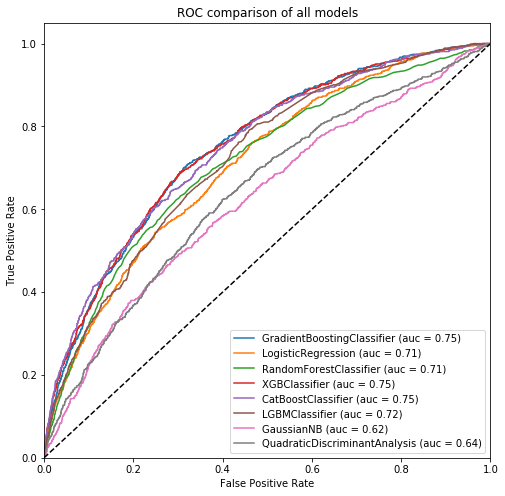

In [32]:
plt.figure(figsize=(8,8))
for i in range(len(modeling.pred_proba)):
    plt.plot(
        fpr[i],
        tpr[i],
        label='{0} (auc = {1:0.2f})'
        ''.format(modeling.cls_name[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison of all models')
plt.legend(loc="lower right")
plt.show()

### probability distributions

In [33]:
#probability distributions of different models
results = pd.DataFrame(modeling.pred_proba,index=modeling.cls_name).T
results.describe()

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier,GaussianNB,QuadraticDiscriminantAnalysis
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,0.073768,0.073290,0.085237,0.076125,0.071450,0.225235,7.751277e-01,0.574295
std,0.065267,0.052983,0.059373,0.058141,0.067414,0.030514,3.943704e-01,0.420744
min,0.010090,0.003137,0.000000,0.007828,0.002437,0.182319,1.134660e-66,0.000000
25%,0.035437,0.036423,0.043000,0.039126,0.030025,0.202737,8.712436e-01,0.065283
50%,0.056530,0.061451,0.071000,0.063358,0.054247,0.222402,9.910881e-01,0.766629
75%,0.088107,0.093674,0.113000,0.093861,0.089059,0.235036,9.974523e-01,0.987311
max,0.910840,0.652749,0.463000,0.677832,0.924632,0.471709,1.000000e+00,1.000000


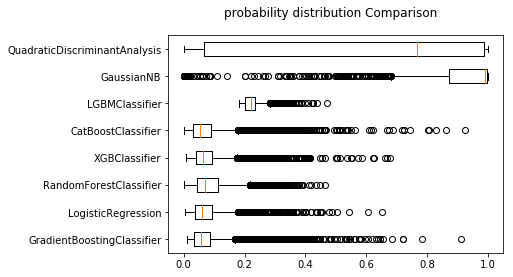

In [34]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('probability distribution Comparison')
ax = fig.add_subplot(111)
plt.boxplot(modeling.pred_proba,vert=False)
ax.set_yticklabels(modeling.cls_name)
plt.show()

# Probability Calibration

## plot

In [35]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [64]:
#calculate ROC and Brier score
axis_x = dict()
axis_y = dict()
brier_score = []
for i in range(len(modeling.pred_proba)):
    axis_y[i], axis_x[i] = calibration_curve(y_test, modeling.pred_proba[i], n_bins=10)
    brier_score.append(brier_score_loss(y_test, modeling.pred_proba[i]))

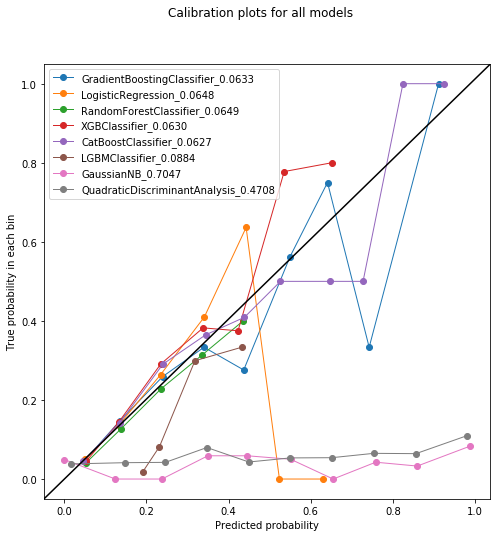

In [66]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(8, 8))
for i in range(len(modeling.pred_proba)):
    plt.plot(
        axis_x[i],
        axis_y[i],
        marker='o',
        linewidth=1,
        label='{}_{:.4f}'.format(modeling.cls_name[i],brier_score[i]))

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plots for all models')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

## calibrate

### xgb

In [38]:
xgb_best_params = modeling.get_models()[3].get_params()

In [39]:
xgb_best = XGBClassifier(**xgb_best_params)
isotonic = CalibratedClassifierCV(xgb_best, cv=5, method='isotonic')
sigmoid = CalibratedClassifierCV(xgb_best, cv=5, method='sigmoid')

In [40]:
names_cali = ['xgb','xgb_isotonic','xgb_sigmoid']

In [41]:
y_pred_cal = []
for cls in [xgb_best,isotonic,sigmoid]:
    cls.fit(X_train,y_train)
    y_pred_cal.append(cls.predict_proba(X_test)[:, 1])    

In [55]:
axis_x = dict()
axis_y = dict()
brier_xgb = []
for i in range(3):
    axis_y[i], axis_x[i] = calibration_curve(y_test, y_pred_cal[i], n_bins=10)
    brier_xgb.append(brier_score_loss(y_test, y_pred_cal[i]))

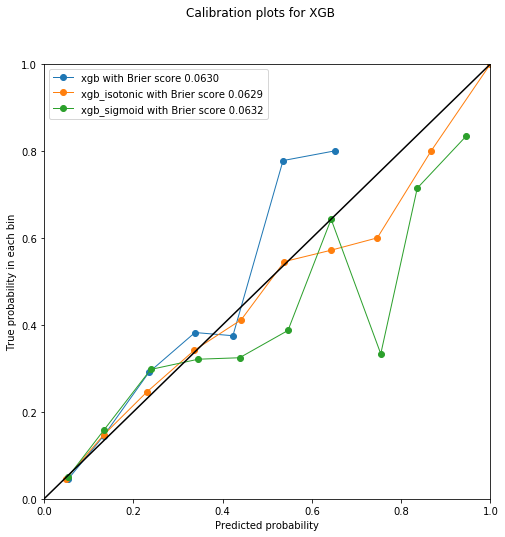

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(8, 8))
for i in range(3):
    plt.plot(
        axis_x[i],
        axis_y[i],
        marker='o',
        linewidth=1,
        label='{} with Brier score {:0.4f}'.format(names_cali[i],brier_xgb[i]))

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plots for XGB')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.legend()
plt.show()

# Ensembling

## Mean

In [44]:
prob_avg = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].mean(axis=1)

roc_auc_score(y_test, prob_avg)

0.7535345739691152

## Minimum

In [45]:
prob_min = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].min(axis=1)

roc_auc_score(y_test, prob_min)

0.7502756113440423

## Maximum

In [46]:
prob_max = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].max(axis=1)

roc_auc_score(y_test, prob_max)

0.7285489978009905

## Median

In [47]:
prob_median = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].median(axis=1)

roc_auc_score(y_test, prob_median)

0.7543680244378823

# Stacking

In [48]:
from Stacking import Stacking

## Model

In [49]:
xgb_best_params = modeling.get_models()[3].get_params()
xgb_best = XGBClassifier(**xgb_best_params)

lgb_best_params = modeling.get_models()[5].get_params()
lgb_best = LGBMClassifier(**lgb_best_params)

rf_best = RandomForestClassifier(n_estimators = 1000)

log_model = LogisticRegression()

In [50]:
stack = Stacking(
    n_splits=3, stacker=log_model, base_models=(xgb_best, lgb_best, rf_best))

y_pred_stack = stack.fit_predict(X_train, y_train, X_test)

inside
Fit XGBClassifier fold 1
Fit XGBClassifier fold 2
Fit XGBClassifier fold 3
Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit RandomForestClassifier fold 1
Fit RandomForestClassifier fold 2
Fit RandomForestClassifier fold 3
Stacker score: 0.72045


## Performance

In [51]:
roc_auc_score(y_test, y_pred_stack)

0.7492771910550482

## Probability Calibration 

In [52]:
ensemble_preds = [prob_avg,prob_min,prob_max,prob_median,y_pred_stack]
ensemble_names = ['prob_avg','prob_min','prob_max','prob_median','y_pred_stack']

In [53]:
axis_x = dict()
axis_y = dict()
for i in range(len(ensemble_preds)):
    axis_y[i], axis_x[i] = calibration_curve(y_test, ensemble_preds[i], n_bins=10)

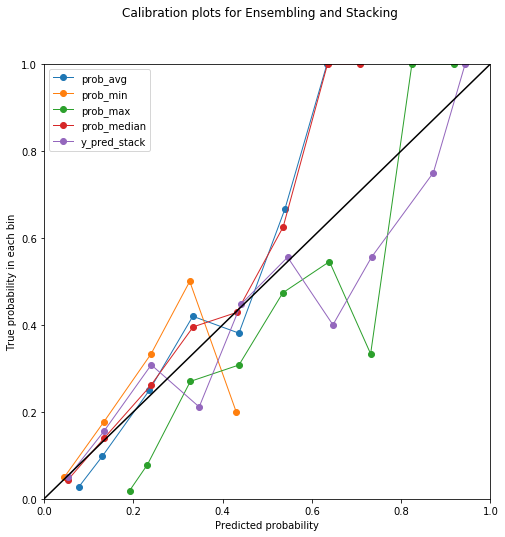

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(8, 8))
for i in range(len(ensemble_preds)):
    plt.plot(
        axis_x[i], axis_y[i], marker='o', linewidth=1, label=ensemble_names[i])

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plots for Ensembling and Stacking')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.legend()
plt.show()